# Day 39

I'm adding onto yesterday's query by filtering for number 1 overall draft picks that finished outside the 1st round. I bet most of those finishes are due to injury so I will also join against the injury table I have from the nflverse data in my database.

In [58]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('deep')

# Create database connection
conn = sqlite3.connect('../../data/db/database.db')

## Query the Data

In [68]:
query = """
WITH adp_cleaned AS (
    SELECT
        scoring,
        season,
        teams AS league_size,
        CASE
            WHEN player_id = 2071 AND name = 'CJ Anderson' THEN 'C.J. Anderson'
            ELSE name
        END AS player_name,
        position AS pos,
        /*
        ADP dataset has the most recent team that a player has played for, regardless of season.
        So I'll need to update teams for certain player-season combinations in order to join
        against the nflverse data which contains the player's fantasy points by season
        */
        CASE
            WHEN player_id = 1347 AND name = 'Chris Johnson' THEN 'TEN'
            WHEN player_id = 1340 AND name = 'Fred Jackson' AND season < 2015 THEN 'BUF'
            WHEN player_id = 1340 AND name = 'Fred Jackson' AND season = 2015 THEN 'SEA'
            WHEN player_id = 1728 AND name = 'C.J. Spiller' AND season < 2014 THEN 'BUF'
            WHEN player_id = 1728 AND name = 'C.J. Spiller' AND season = 2015 THEN 'NO'
            WHEN player_id = 649 AND name = 'Maurice Jones-Drew' AND season < 2014 THEN 'JAX'
            ELSE team
        END AS team,
        adp_formatted,
        round,
        pick
    FROM adp),
season_summary AS (
    SELECT
        player_id,
        -- Data Cleaning for future join against ADP table
        CASE
            WHEN player_display_name = "Le'Veon Bell" THEN "LeVeon Bell"
            WHEN player_display_name = "Odell Beckham" THEN "Odell Beckham Jr"
            WHEN player_display_name = "Mike Vick" THEN "Michael Vick"
            WHEN player_display_name = "DK Metcalf" THEN "D.K. Metcalf"
            ELSE player_display_name
        END AS player_name,
        season,
        -- Data Cleaning for future join against ADP table
        CASE 
            WHEN player_id = "00-0029675" AND player_display_name = "Trent Richardson" THEN "RB"
            ELSE position
        END AS pos,
        -- Data Cleaning for future join against ADP table
        CASE
            WHEN recent_team = 'LA' THEN 'LAR'
            ELSE recent_team
        END AS team,
        ROUND(SUM(fantasy_points), 2) AS tot_pts,
        ROUND(SUM(fantasy_points_ppr), 2) AS tot_pts_ppr
    FROM 
        /* 
        The ADP table that I will eventually join against has the last team a player
        played for in a given season. In the case of players that were traded 
        at least once in a season, if I group by player name with player-week records in
        ascending order (by week) I'll get their earliest team. So I need to order by 
        most recent week to get the last team they played for when I aggregate.
        */
        (
            SELECT  *
            FROM weekly
            ORDER BY week DESC 
        ) AS weekly
    WHERE season_type = 'REG' 
        AND player_display_name IS NOT NULL
    GROUP BY player_id, player_display_name, season),
rankings AS (
    SELECT
        *,
        RANK() OVER(PARTITION BY season ORDER BY tot_pts DESC) AS r_pts,
        RANK() OVER(PARTITION BY season ORDER BY tot_pts_ppr DESC) AS r_pts_ppr
    FROM season_summary), 
joined AS (   
    SELECT
        adp_cleaned.*, 
        rankings.*, 
        weeks_injured
    FROM adp_cleaned
    LEFT JOIN rankings
        ON rankings.player_name = adp_cleaned.player_name
        AND rankings.season = adp_cleaned.season
        -- Additional join keys added in case multiple players have same name
        AND rankings.pos = adp_cleaned.pos
        AND rankings.team = adp_cleaned.team
    LEFT JOIN (
        SELECT *, COUNT(*) AS weeks_injured
        FROM injuries
        WHERE practice_status LIKE 'OUT%'
            OR practice_status LIKE 'Did Not Participate%'
        GROUP BY season, full_name, team, position
    ) AS injuries
        ON injuries.season = adp_cleaned.season
        AND injuries.full_name = adp_cleaned.player_name
        -- Additional join keys added in case multiple players have same name
        AND injuries.team = adp_cleaned.team
        AND injuries.position = adp_cleaned.pos),
first_and_second_round_picks AS (
    SELECT
        scoring,
        season,
        league_size,
        player_id,
        player_name,
        pos,
        team,
        adp_formatted,
        tot_pts_ppr,
        -- r_pts,
        r_pts_ppr,
        weeks_injured
    FROM joined
    WHERE round = 1
        OR round = 2)
SELECT * 
FROM first_and_second_round_picks
WHERE scoring = 'ppr'
    -- AND league_size = 10
"""

df = pd.read_sql(query, conn)
df.head(10)

,scoring,season,league_size,player_id,player_name,pos,team,adp_formatted,tot_pts_ppr,r_pts_ppr,weeks_injured
0,ppr,2010,10,00-0026164,Chris Johnson,RB,TEN,1.01,272.90,17.0,NaN
1,ppr,2010,10,00-0025394,Adrian Peterson,RB,MIN,1.02,275.90,15.0,NaN
2,ppr,2010,10,00-0026195,Ray Rice,RB,BAL,1.03,276.60,14.0,NaN
3,ppr,2010,10,00-0024275,Maurice Jones-Drew,RB,JAX,1.05,234.10,35.0,2.0
4,ppr,2010,10,00-0022044,Andre Johnson,WR,HOU,1.05,256.60,23.0,3.0
5,ppr,2010,10,00-0023500,Frank Gore,RB,SF,1.06,202.50,56.0,NaN
6,ppr,2010,10,00-0023459,Aaron Rodgers,QB,GB,1.08,304.48,4.0,1.0
7,ppr,2010,10,00-0011754,Randy Moss,WR,TEN,1.08,97.30,178.0,NaN
8,ppr,2010,10,00-0022821,Michael Turner,RB,ATL,1.09,225.60,42.0,NaN
9,ppr,2010,10,00-0020498,Reggie Wayne,WR,IND,2.01,280.50,12.0,1.0


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528 entries, 0 to 527
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   scoring        528 non-null    object 
 1   season         528 non-null    int64  
 2   league_size    528 non-null    int64  
 3   player_id      525 non-null    object 
 4   player_name    528 non-null    object 
 5   pos            528 non-null    object 
 6   team           528 non-null    object 
 7   adp_formatted  528 non-null    object 
 8   tot_pts_ppr    525 non-null    float64
 9   r_pts_ppr      525 non-null    float64
 10  weeks_injured  248 non-null    float64
dtypes: float64(3), int64(2), object(6)
memory usage: 45.5+ KB


In [70]:
df[df['r_pts_ppr'].isnull()]

,scoring,season,league_size,player_id,player_name,pos,team,adp_formatted,tot_pts_ppr,r_pts_ppr,weeks_injured
161,ppr,2018,10,None,LeVeon Bell,RB,PIT,1.03,NaN,NaN,NaN
306,ppr,2012,12,None,Steven Jackson,RB,ATL,2.09,NaN,NaN,NaN
433,ppr,2018,12,None,LeVeon Bell,RB,PIT,1.03,NaN,NaN,NaN


This is the season where Le'Veon Bell sat out for the entire season. Fantasy managers who picked him in the first round ended up losing out big time!

In [71]:
df[df['weeks_injured'].isnull()]

,scoring,season,league_size,player_id,player_name,pos,team,adp_formatted,tot_pts_ppr,r_pts_ppr,weeks_injured
0,ppr,2010,10,00-0026164,Chris Johnson,RB,TEN,1.01,272.90,17.0,NaN
1,ppr,2010,10,00-0025394,Adrian Peterson,RB,MIN,1.02,275.90,15.0,NaN
2,ppr,2010,10,00-0026195,Ray Rice,RB,BAL,1.03,276.60,14.0,NaN
5,ppr,2010,10,00-0023500,Frank Gore,RB,SF,1.06,202.50,56.0,NaN
7,ppr,2010,10,00-0011754,Randy Moss,WR,TEN,1.08,97.30,178.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
516,ppr,2021,12,00-0036893,Najee Harris,RB,PIT,2.01,300.70,18.0,NaN
518,ppr,2021,12,00-0036223,Jonathan Taylor,RB,IND,2.02,373.10,5.0,NaN
523,ppr,2021,12,00-0035640,D.K. Metcalf,WR,SEA,2.08,244.30,37.0,NaN
526,ppr,2021,12,00-0036322,Justin Jefferson,WR,MIN,2.10,330.40,11.0,NaN


These are players that never showed up in the injuries table. My guess is that they end up scoring more in fantasy, on average, than players drafted in the earlier rounds who had injuries during the season. 

In [72]:
df.describe()

,season,league_size,tot_pts_ppr,r_pts_ppr,weeks_injured
count,528.000000,528.000000,525.000000,525.000000,248.000000
mean,2015.607955,11.083333,232.559162,66.979048,2.713710
std,3.437114,0.997467,90.249478,83.852569,2.287683
min,2010.000000,10.000000,9.000000,1.000000,1.000000
25%,2013.000000,10.000000,178.200000,13.000000,1.000000
50%,2016.000000,12.000000,234.100000,38.000000,2.000000
75%,2019.000000,12.000000,303.100000,84.000000,4.000000
max,2021.000000,12.000000,471.200000,434.000000,15.000000


## Cleaning

In [93]:
def get_pick(row):
    round = int(row['adp_formatted'].split('.')[0])
    
    if row['league_size'] == 10:
        if round == 1:
            pick = int(row['adp_formatted'].split('.')[1])
        elif round == 2:
            pick = (round + int(row['adp_formatted'].split('.')[1])) + 8
    elif row['league_size'] == 12:
        if round == 1:
            pick = int(row['adp_formatted'].split('.')[1])
        elif round == 2:
            pick = (round + int(row['adp_formatted'].split('.')[1])) + 10

    return pick

df['pick'] = df.apply(lambda row: get_pick(row), axis=1)

## Exploratory Data Analysis

In [94]:
order = list(df.adp_formatted.unique())
order.sort()
order[:5]

['1.01', '1.02', '1.03', '1.04', '1.05']

In [95]:
# Remove outliers
df_rm_outliers = df.query("r_pts_ppr < 100")

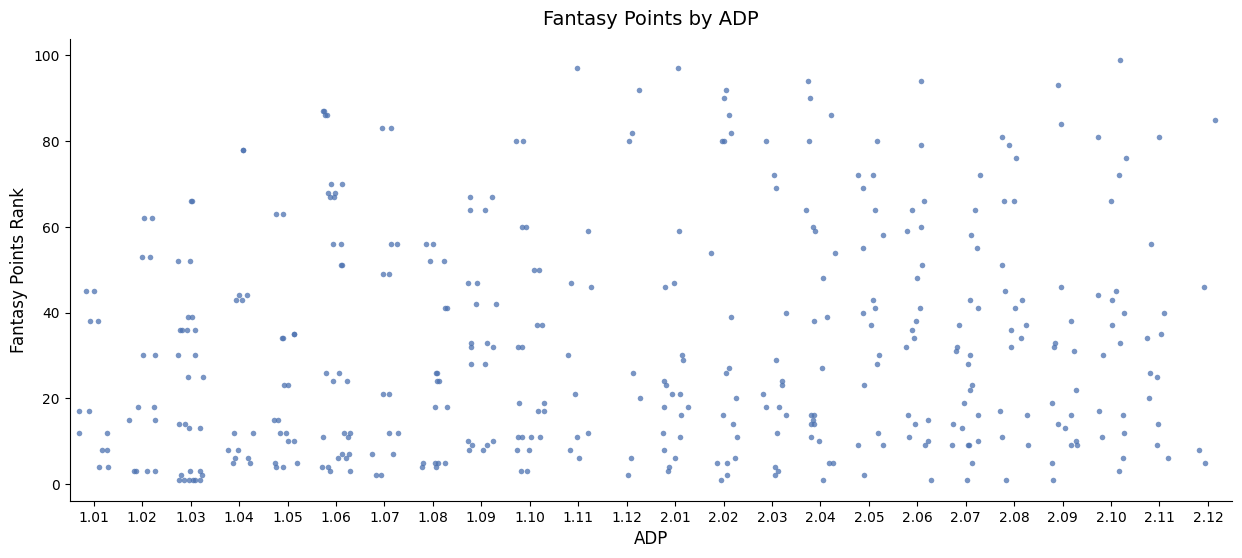

In [96]:
# Change plot size
plt.figure(figsize = (15, 6))

g = sns.stripplot(data=df_rm_outliers,
                  x='adp_formatted',
                  y='r_pts_ppr',
                  jitter=0.30,
                  size=4,
                  alpha=0.75,
                #   hue='material',
                  order=order,
                  legend=None)

# Add labels and title
g.set_xlabel("ADP", size=12)
g.set_ylabel("Fantasy Points Rank", size=12)
g.set_title("Fantasy Points by ADP", size=14, pad=10)

sns.despine()
plt.show()

/Volumes/develop/projects/fantasy_football_analysis/env/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 10.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Volumes/develop/projects/fantasy_football_analysis/env/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


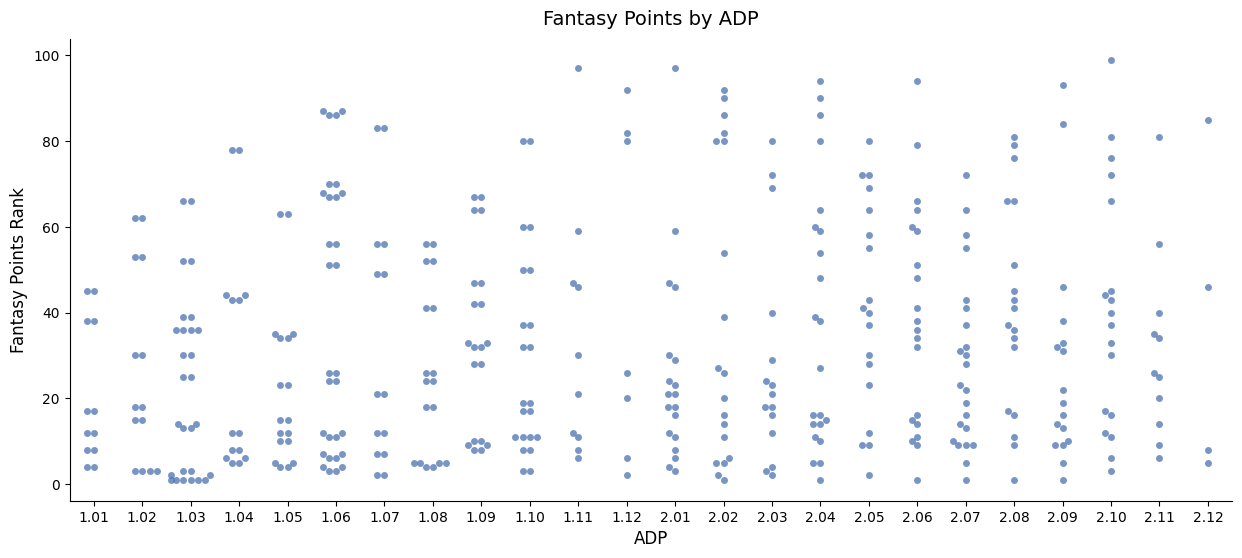

In [97]:
# Change plot size
plt.figure(figsize = (15, 6))

g = sns.swarmplot(data=df_rm_outliers,
                  x='adp_formatted',
                  y='r_pts_ppr',
                #   jitter=0.30,
                #   size=4,
                  alpha=0.75,
                #   hue='material',
                  order=order,
                  legend=None)

# Add labels and title
g.set_xlabel("ADP", size=12)
g.set_ylabel("Fantasy Points Rank", size=12)
g.set_title("Fantasy Points by ADP", size=14, pad=10)

sns.despine()
plt.show()

/Volumes/develop/projects/fantasy_football_analysis/env/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


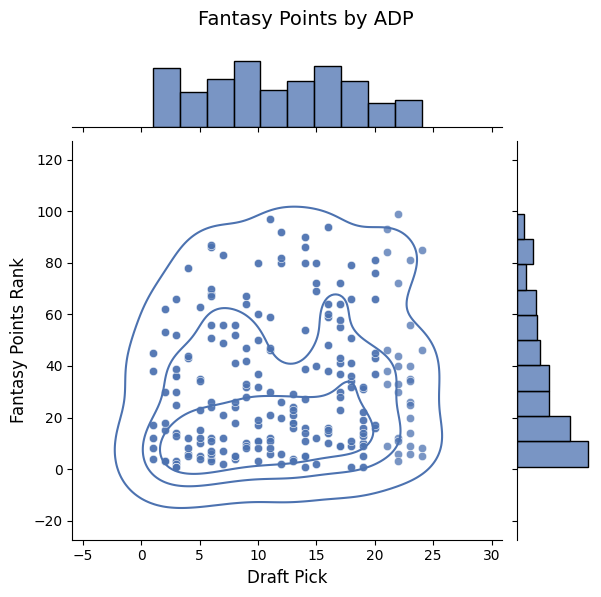

In [108]:
g = sns.jointplot(x="pick",
                  y='r_pts_ppr',
                  kind='scatter',
                  data=df_rm_outliers,
                #   hue='condition',
                  alpha=0.75
                  )
                  
g.plot_joint(sns.kdeplot, levels=4, linewidth=1)

# Add labels and title
plt.xlabel("Draft Pick", size=12)
plt.ylabel("Fantasy Points Rank", size=12)
g.fig.suptitle("Fantasy Points by ADP", size=14)

g.fig.subplots_adjust(top=0.9)

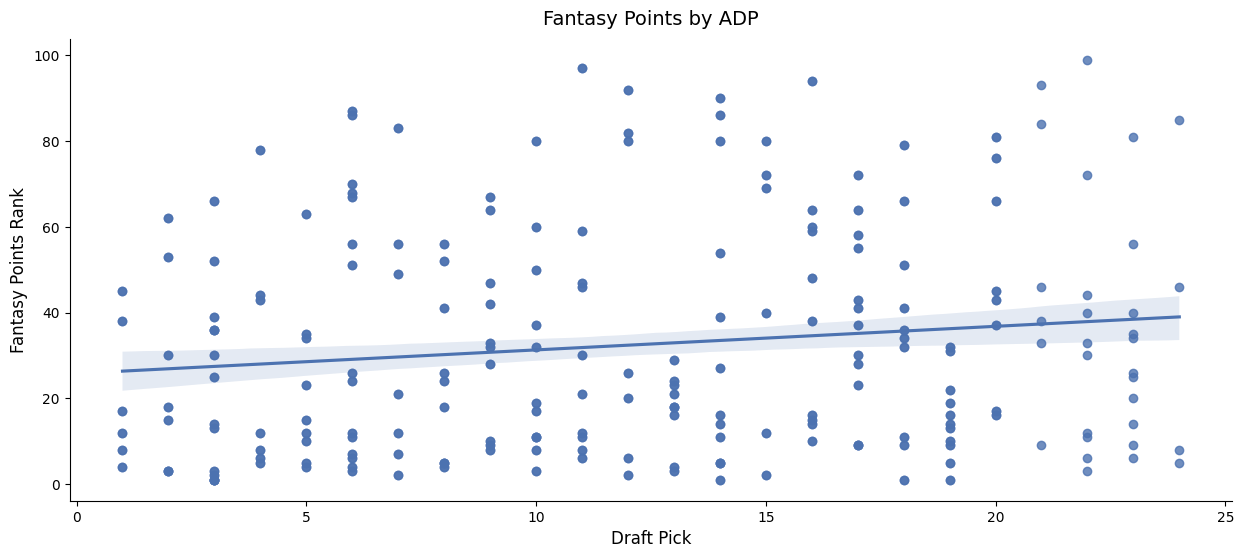

In [112]:
# Change plot size
plt.figure(figsize = (15, 6))

g = sns.regplot(data=df_rm_outliers,
            x='pick',
            y='r_pts_ppr')

# Add labels and title
g.set_xlabel("Draft Pick", size=12)
g.set_ylabel("Fantasy Points Rank", size=12)
g.set_title("Fantasy Points by ADP", size=14, pad=10)

sns.despine()
plt.show()

No real relationship between draft pick and end of season fantasy points ranking, at least for the first two rounds of a fantasy draft